In [156]:
# Importar librerias standard de Qiskit
from qiskit import *
from qiskit.quantum_info import Operator
from qiskit.circuit.library import *
from qiskit.visualization import *
from qiskit_ibm_runtime import *
from qiskit_aer import *

import numpy as np

service = QiskitRuntimeService(channel="local")

In [174]:
def ket_reg(n, x):
    if x < 0 or x > 2**n-1:
        return(-1)
    output = [[0] for i in range(x)]+[[1]]+ [[0] for i in range(2**n-x-1)]
    return(np.matrix(output))
def bra_reg(n,x):
    return(ket_reg(n,x).H)

def Oracle(n, f):
    dim = 2**(n+1)  #n qubits entrada + 1 qubit salida
    unitary = np.zeros((dim, dim), dtype=complex)

    I = np.matrix([[1,0],
                   [0,1]])
    X = np.matrix([[0,1],
                   [1,0]])

    for x in range(2**n):
        if f(x) == 0:
            unitary += np.kron(I, ket_reg(n, x) @ bra_reg(n, x))
        else:
            unitary += np.kron(X, ket_reg(n, x) @ bra_reg(n, x))

    return UnitaryGate(unitary, label='U_f')

In [184]:
def xor_num(x):
    sum = 0
    for b in bin(x)[2:]:
        sum += int(b)
    
    return sum % 2

def BernsteinVazirani(s):
    def f(x):
        return xor_num(np.bitwise_and(x, s))
    return f

In [185]:
print(np.bitwise_and(5, 1))

print(BernsteinVazirani(1)(5))

1
1


In [186]:
def BernsteinVazirani_circuit(function, n):
    x = QuantumRegister(n, 'x')
    y = QuantumRegister(1, 'y')
    measure_bit = ClassicalRegister(n,'measure')
    
    qc = QuantumCircuit(x,y,measure_bit)

    qc.h(x)
    qc.x(y)
    qc.h(y)

    qc.barrier()
    
    qc.append(Oracle(n, function), list(x) + list(y))

    qc.barrier()
    
    qc.h(x)

    qc.measure(x, measure_bit)
    return(qc)
    

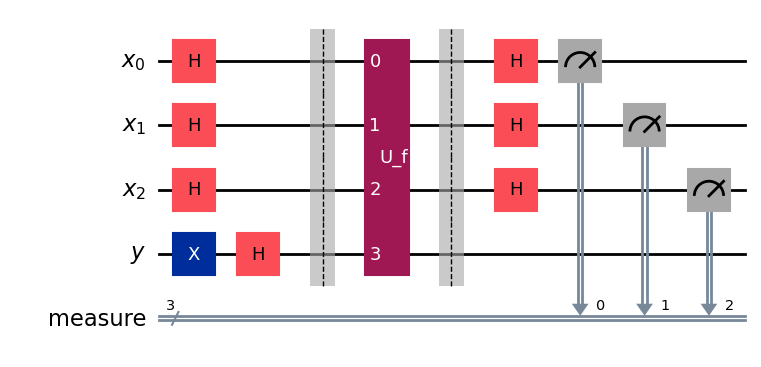

In [188]:
qc = BernsteinVazirani_circuit(BernsteinVazirani(5), 3);

qc.draw('mpl')

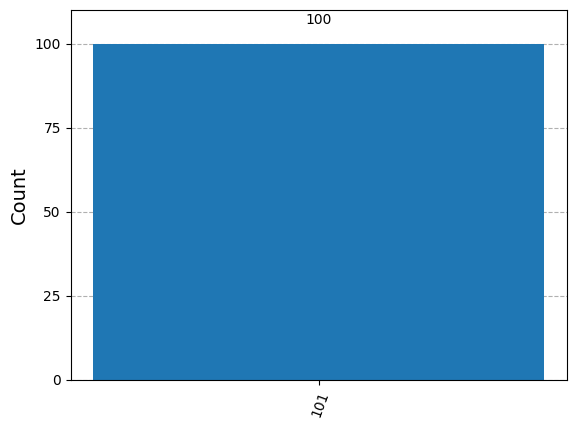

In [189]:
# Transpile for simulator
simulator = AerSimulator()
circuit = transpile(qc, simulator)

# Run and get counts
SHOTS = 100
result = simulator.run(circuit,shots=SHOTS).result()
counts = result.get_counts()
plot_histogram(counts)